In [76]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
from mpl_toolkits.mplot3d import Axes3D #, axes3d

In [77]:
def make_pipe_clf(scaler,feature_selection,decomp,clf):
    order = 1
# order = 1 : first perform feature selection and then apply PCA
# order = 0 : first apply PCA and then reduce the transformed features
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                    ('classifier', clf) ])
#     else:
#         pipeline = Pipeline([('scaler', scaler),
#                     ('decomp', decomp ),                 
#                     ('feature_selection', feature_selection),        
#                     ('classifier', clf) ])
    return pipeline
###########################################################################################
def make_pipe(scaler,feature_selection,decomp,order):
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                     ])
    else:
        pipeline = Pipeline([('scaler', scaler),
                    ('decomp', decomp ),                 
                    ('feature_selection', feature_selection),        
                     ])
    return pipeline

In [226]:
class Nested_cv:
    def __init__(self, n_outer_folds = 3, n_inner_folds = 3, n_top =1, state = 42):
        self.n_outer_folds = n_outer_folds
        self.n_inner_folds = n_inner_folds
        self.n_top = n_top
        self.state = state
#         print("constructor %d" %self.state)
                                        
    def set_pipe(self, pip_steps, pip_params):
        n_steps = len(pip_steps)
        if n_steps == 3:
            self.pipe = make_pipe(scaler = pip_steps[0], feature_selection = pip_steps[1], decomp = pip_steps[2])
            self.params = pip_params
        if n_steps == 4:
            self.pipe = make_pipe_clf(scaler = pip_steps[0], feature_selection = pip_steps[1], decomp = pip_steps[2], clf = pip_steps[3])
            self.params = pip_params
        else:
            print ("Number of steps gotta be either 3 or 4, you inserted %d." %n_steps)
        return self.pipe
        
    def fit(self, x_tot, y_tot, verbose = 0):
        self.verbose = verbose
#         print("fit %d" %self.state)
        if self.n_top >1 :
            print ("ACHTUNG! You need to use fit2 for multiple best models!")
            self.fit2(x_tot,y_tot)
        else:
            self.outer_cv = StratifiedKFold(n_splits = self.n_outer_folds, shuffle = True, random_state = self.state)
            self.inner_cv = StratifiedKFold(n_splits = self.n_inner_folds, shuffle = True, random_state = self.state)
            self.grid = GridSearchCV(self.pipe, self.params, cv = self.inner_cv, verbose = self.verbose)       
            self.score = cross_val_score(self.grid, X = x_tot, y = y_tot, cv = self.outer_cv, verbose = self.verbose)

    def get_outer_scores(self):
        return self.score
    
    def get_mean_score(self):
        self.mean_score = self.score.mean()
        print ("Mean score of %d outer folds : %f" %(self.n_outer_folds, self.mean_score ))
        return self.mean_score
    
    def combinations(self):
        self.comb = 1
        for self.key in self.params.keys():
            self.comb =self.comb*len(self.params[self.key])
        return self.comb
    
    def get_feat_scores(self):
        return self.total_feats
    
    def print_feat_scores(self):
        self.norm_total_feats = (self.total_feats)/(self.n_inner_folds * self.n_top)
        plt.figure()
        self.rel_score = plt.bar(range(len(self.total_feats)),self.norm_total_feats)
        plt.xlabel("Features")
        plt.ylabel("Score")
        plt.show()
        
    
    def repeated_cv(self,x_tot, y_tot, num_trials):
        self.repeated = np.zeros(num_trials)
        self.rep_feat_scores = np.zeros(x_tot.shape[1])
        self.num_trials = num_trials
        self.state +=1
        for st in range(self.num_trials):
            self.state +=1
            self.fit(x_tot, y_tot)
#             print("repeated %d" %self.state)
            self.out = self.get_outer_scores()
            self.rep_feat_scores += self.get_feat_scores()
            self.repeated[st] = self.out.mean()
            
        plt.figure()
        self.rep_sc_plot = plt.bar(range(num_trials),self.repeated)
        plt.xlabel("Individual trial #")
        plt.ylabel("Outer mean scores")
        plt.show()
    
    def print_rep_feat_scores(self):
        plt.figure()
        self.norm_rep_feats = (self.rep_feat_scores)/(self.n_inner_folds*self.n_top*self.num_trials)
        self.rel_score = plt.bar(range(len(self.total_feats)),self.norm_rep_feats)
        plt.xlabel("Features")
        plt.ylabel("Feature Score")
        plt.show()
        
    def get_rep_feat_scores(self):
        return self.rep_feat_scores
        
    def fit2(self,x_tot, y_tot):
        #the "handwritten" implementation
        self.total_feats = np.zeros(x_tot.shape[1])
        self.classifiers= list(ParameterGrid(self.params))
        self.outer_scores = np.zeros((self.n_top, self.n_outer_folds))
#         self.ncomp = self.params['decomp__n_components']
#         self.best_feat_ind = []
        self.best_pipes = [[],[]]
        self.outer_cv = StratifiedKFold(n_splits = self.n_outer_folds, shuffle = True, random_state = self.state)
        self.inner_cv = StratifiedKFold(n_splits = self.n_inner_folds, shuffle = True, random_state = self.state)
        self.outer = self.outer_cv.split(x_tot,y_tot)
        for self.fold_out, (self.train_ind_out,self.test_ind_out) in enumerate(self.outer):
            top_models = []
            if self.verbose>0 :
                print("Outer loop %d/%d" %((self.fold_out + 1), self.n_outer_folds))
        # split the dataset 
            self.x_trn_out, self.x_tst_out = x_tot[self.train_ind_out], x_tot[self.test_ind_out]
            self.y_trn_out, self.y_tst_out = y_tot[self.train_ind_out], y_tot[self.test_ind_out]  
            
            self.inner_scores = np.zeros((len(self.classifiers),self.n_inner_folds))
            self.inner_mean_scores = np.zeros(len(self.classifiers))
            
            for self.cl_ind, self.clf in enumerate(self.classifiers):
                self.inner = self.inner_cv.split(self.x_trn_out, self.y_trn_out)
                self.nfeat = self.classifiers[self.cl_ind]['feature_selection__k']
                self.best_feat_ind = np.zeros((self.n_top, self.nfeat))


                for self.fold_in, (self.train_ind_in, self.test_ind_in) in enumerate(self.inner): 
                    if self.verbose>0 :
                        print("Inner fold %d/%d" % ((self.fold_in + 1), self.n_inner_folds ))
                    # split the datasets for the inner cv 
                    self.x_trn_in, self.x_tst_in = self.x_trn_out[self.train_ind_in], self.x_trn_out[self.test_ind_in]
                    self.y_trn_in, self.y_tst_in = self.y_trn_out[self.train_ind_in], self.y_trn_out[self.test_ind_in]
                    self.pip = self.pipe.set_params(**self.clf)
                    self.pip.fit(self.x_trn_in,self.y_trn_in)
                    self.inner_scores[self.cl_ind][self.fold_in] = self.pip.score(self.x_tst_in, self.y_tst_in)

            # get the mean performance for every classifier
            self.inner_mean_scores = np.mean(self.inner_scores, axis = 1)
#             print('\n',self.inner_mean_scores)

            # sort the scores, low -> high 
            self.sorted_inds = self.inner_mean_scores.argsort()
            self.sorted_scores = self.inner_mean_scores[self.sorted_inds]

            print ("Best %d models for outer fold %d are: \n " %(self.n_top, (self.fold_out+1)))

#             get the inds of best performing models
            self.temp2 = 0
            for self.temp_ind in range(-1, -(self.n_top +1), -1):
                self.actual_ind = self.sorted_inds[self.temp_ind]
                self.best_pipes[1].append(self.classifiers[self.actual_ind]) 
                self.best_pipes[0].append(self.fold_out)
                print("model no.%d "%(self.actual_ind + 1))
                print(self.classifiers[self.actual_ind])
                #print the top features selected
                self.best_fs = self.pipe.set_params(**self.classifiers[self.actual_ind]).named_steps['feature_selection']
#                 best_fs = pipeline[actual_ind].named_steps['feature_selection']
                self.pipe_fs_unsorted = self.best_fs.scores_
                self.fs_inds = self.pipe_fs_unsorted.argsort()
#                 print(self.fs_inds)
                self.pipe_fs = self.pipe_fs_unsorted[self.fs_inds]
                self.temp3 = 0 # temp3 = 0:number of features
               
                for self.temp_ind2 in range(-1, -(self.nfeat +1), -1):         
                    self.best_feat_ind[self.temp2][self.temp3]=self.fs_inds[self.temp_ind2]
                    self.total_feats[self.fs_inds[self.temp_ind2]]+=1 # feature scores 
                    self.temp3+=1

                #fit the best classifier on the outer test data
                self.best_pip = self.pipe.set_params(**self.classifiers[self.actual_ind])
                
                self.best_pip.fit(self.x_trn_out, self.y_trn_out)
                
                #get the outer score 
                self.outer_scores[self.temp2, self.fold_out] = self.best_pip.score(self.x_tst_out, self.y_tst_out)
                print("Inner score: %f VS Outer score: %f \n" %(self.inner_mean_scores[self.actual_ind], self.outer_scores[self.temp2, self.fold_out]))
                print ("----------------------------------------------------------")
                self.temp2+=1


#             print("Features selected: \n")
        #     print(best_feat_ind.sort())     
#             print(self.best_feat_ind)
        # print(outer_scores)  
        # print(best_pipes)
        self.score = self.outer_scores
        


In [ ]:
#================================================
#==================  EXAMPLE ====================
#================================================

In [90]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("sonar.csv",header = None)
dataset = df.values
Xsonar = dataset[:, 0:60].astype(float)
Ysonar = dataset[:,60]
#change the string output to int 
encoder = LabelEncoder()
encoder.fit(Ysonar)
ysonar = encoder.transform(Ysonar)

In [227]:
nest = Nested_cv(n_outer_folds= 5, n_inner_folds =5, n_top=2, state = 2)
steps = [StandardScaler(), SelectKBest(), PCA(), SVC()]
params = {'feature_selection__k' : [40], 'decomp__n_components':[30,20], 'classifier__kernel' : ['rbf'], 'classifier__C': [1,1000], 'classifier__gamma': [0.1,5]}
nest.set_pipe(pip_params= params, pip_steps=steps)
nest.fit(Xsonar,Ysonar)


ACHTUNG! You need to use fit2 for multiple best models!
Best 2 models for outer fold 1 are: 
 
model no.6 
{'classifier__C': 1000, 'classifier__gamma': 0.1, 'decomp__n_components': 20, 'feature_selection__k': 40, 'classifier__kernel': 'rbf'}
Inner score: 0.843761 VS Outer score: 0.860465 

----------------------------------------------------------
model no.2 
{'classifier__C': 1, 'classifier__gamma': 0.1, 'decomp__n_components': 20, 'feature_selection__k': 40, 'classifier__kernel': 'rbf'}
Inner score: 0.825011 VS Outer score: 0.837209 

----------------------------------------------------------
Best 2 models for outer fold 2 are: 
 
model no.6 
{'classifier__C': 1000, 'classifier__gamma': 0.1, 'decomp__n_components': 20, 'feature_selection__k': 40, 'classifier__kernel': 'rbf'}
Inner score: 0.820455 VS Outer score: 0.880952 

----------------------------------------------------------
model no.2 
{'classifier__C': 1, 'classifier__gamma': 0.1, 'decomp__n_components': 20, 'feature_selectio

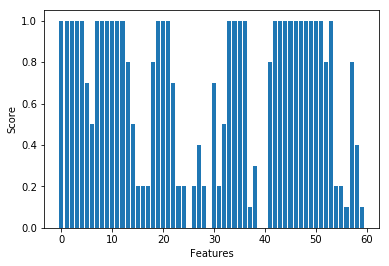

[ 10.  10.  10.  10.  10.   7.   5.  10.  10.  10.  10.  10.  10.   8.   5.
   2.   2.   2.   8.  10.  10.  10.   7.   2.   2.   0.   2.   4.   2.   0.
   7.   2.   5.  10.  10.  10.  10.   1.   3.   0.   0.   8.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.   8.  10.   2.   2.   1.   8.   4.   1.]


In [228]:
sx = nest.print_feat_scores()
print(nest.get_feat_scores())

ACHTUNG! You need to use fit2 for multiple best models!
Best 2 models for outer fold 1 are: 
 
model no.6 
{'classifier__C': 1000, 'classifier__gamma': 0.1, 'decomp__n_components': 20, 'feature_selection__k': 40, 'classifier__kernel': 'rbf'}
Inner score: 0.824476 VS Outer score: 0.837209 

----------------------------------------------------------
model no.5 
{'classifier__C': 1000, 'classifier__gamma': 0.1, 'decomp__n_components': 30, 'feature_selection__k': 40, 'classifier__kernel': 'rbf'}
Inner score: 0.817313 VS Outer score: 0.813953 

----------------------------------------------------------
Best 2 models for outer fold 2 are: 
 
model no.6 
{'classifier__C': 1000, 'classifier__gamma': 0.1, 'decomp__n_components': 20, 'feature_selection__k': 40, 'classifier__kernel': 'rbf'}
Inner score: 0.836999 VS Outer score: 0.880952 

----------------------------------------------------------
model no.2 
{'classifier__C': 1, 'classifier__gamma': 0.1, 'decomp__n_components': 20, 'feature_selec

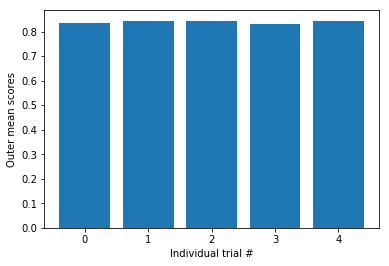

In [229]:
nest.repeated_cv(num_trials=5,x_tot=Xsonar,y_tot=Ysonar)

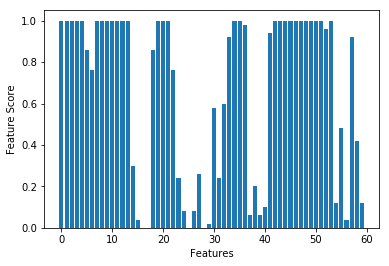

[ 50.  50.  50.  50.  50.  43.  38.  50.  50.  50.  50.  50.  50.  50.  15.
   2.   0.   0.  43.  50.  50.  50.  38.  12.   4.   0.   4.  13.   0.   1.
  29.  12.  30.  46.  50.  50.  49.   3.  10.   3.   5.  47.  50.  50.  50.
  50.  50.  50.  50.  50.  50.  50.  48.  50.   6.  24.   2.  46.  21.   6.]


In [231]:
nest.print_rep_feat_scores()
print(nest.get_rep_feat_scores())